# High-dimensional CVaR optimization
Fast and stable Conditional Value-at-Risk (CVaR) optimization is much harder to implement in practice than variance optimization.

This prevents many people from applying CVaR optimization, despite their wish to do so.

Some people even make up excuses such as "we don't have enough data for CVaR optimization" or "CVaR optimization does not work for high-dimensional optimization".

For a rejection of the the first excuse, see https://antonvorobets.substack.com/p/better-backtesting.

The second excuse is adressed in this example, where we simulate 2000 stocks and show that even the open-source implementation from the fortitudo.tech Python package is capable of handling this optimization in practice.

In [1]:
import numpy as np
import yfinance as yf
import fortitudo.tech as ft
import matplotlib.pyplot as plt
from time import time

# Index data download
We use the same data as in Chapter 2 of the Portfolio Construction and Risk Management book (https://antonvorobets.substack.com/p/pcrm-book) and The Normal Distribution Myth article (https://ssrn.com/abstract=5283255 and https://github.com/fortitudo-tech/fortitudo.tech/blob/main/examples/12_NormalDistributionMyth.ipynb)

In [2]:
tickers = [
    'XLB', 'XLE', 'XLF', 'XLI', 'XLK',
    'XLP', 'XLU', 'XLV', 'XLY', '^GSPC', '^VIX']
data = yf.download(tickers, start='1998-12-22', end='2025-11-15')['Close']

names_dict = {
    'XLB': 'Materials', 'XLE': 'Energy', 'XLF': 'Financial', 'XLI': 'Industrial',
    'XLK': 'Technology', 'XLP': 'Consumer Staples', 'XLU': 'Utilities',
    'XLV': 'Health Care', 'XLY': 'Consumer Discretionary', '^GSPC': 'S&P 500',}
data = data.rename(columns=names_dict)

print(f'The number of daily observations is {len(data)}.')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  11 of 11 completed

The number of daily observations is 6767.


In [3]:
data

Ticker,Materials,Energy,Financial,Industrial,Technology,Consumer Staples,Utilities,Health Care,Consumer Discretionary,S&P 500,^VIX
Date,,,,,,,,,,,
1998-12-22,11.546238,11.646659,11.260053,14.522221,23.912472,14.177594,11.834163,16.930679,18.833811,1203.569946,22.780001
1998-12-23,11.667501,11.889135,11.426087,14.775623,24.483768,14.520323,11.784570,17.311140,18.914694,1228.540039,20.209999
1998-12-24,11.936020,11.826560,11.501559,14.970555,24.390497,14.495246,12.001533,17.416828,19.261330,1226.270020,21.480000
1998-12-28,11.832079,11.763986,11.350622,15.048525,24.460447,14.411647,11.939540,17.163189,19.088005,1225.489990,23.500000
1998-12-29,12.048620,11.881313,11.471372,15.262951,24.530396,14.729318,12.137920,17.543653,19.503969,1241.810059,22.180000
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-10,86.629997,90.349998,52.970001,154.199997,295.529999,76.430000,89.660004,147.279999,238.960007,6832.430176,17.600000
2025-11-11,87.529999,91.529999,53.209999,154.240005,293.010010,77.430000,89.709999,150.679993,239.550003,6846.609863,17.280001
2025-11-12,88.150002,90.250000,53.669998,154.389999,293.920013,77.320000,89.919998,152.820007,237.940002,6850.919922,17.510000


In [4]:
print(f'{np.round(len(data) / 252, 2)} years of daily data.')

26.85 years of daily data.


# Simulation
We use the Fully Flexible Resampling method, introduced in Chapter 3 of the Portfolio Construction and Risk Management book (https://antonvorobets.substack.com/p/pcrm-book), to simulate returns one month ahead (21 trading days). See also the Time- and State-Dependent Resampling article (https://ssrn.com/abstract=5117589 and https://github.com/fortitudo-tech/fortitudo.tech/blob/main/examples/11_TimeStateResampling.ipynb).

After simulating the 10 indices conditional on the VIX index, we simulate S=10,000 joint scenarios for I=2,000 fictitious stocks as random linear combinations of the 10 index returns. The actual simulations are not essential in this case. We just want some non-normal joint scenarios.

Most of the simulation code is a reuse from the original Fully Flexible Resampling code: https://github.com/fortitudo-tech/pcrm-book/blob/main/code/chapter3/chapter3_2_1.ipynb

In [5]:
log_returns = np.diff(np.log(data.values[:, :-1]), axis=0)  # exclude the VIX

In [6]:
stats = ft.simulation_moments(100 * log_returns)
stats.index = data.columns[:-1]
stats

,Mean,Volatility,Skewness,Kurtosis
Ticker,,,,
Materials,0.029809,1.492577,-0.192856,9.525693
Energy,0.030550,1.816603,-0.632104,15.149187
Financial,0.022740,1.795687,-0.136471,17.686106
Industrial,0.034707,1.333945,-0.335679,10.931590
Technology,0.036788,1.632799,0.081877,9.922883
Consumer Staples,0.025059,0.960335,-0.237758,10.948962
Utilities,0.029780,1.216285,-0.053558,14.138125
Health Care,0.032421,1.127539,-0.215233,11.748162
Consumer Discretionary,0.037042,1.434766,-0.347574,9.520665


In [7]:
# VIX only state variable
vix = data.values[1:, -1]  # exclude first VIX observation to match returns
imp_vol_25pct = np.percentile(vix, 25)
low_vol_indices = vix <= imp_vol_25pct
imp_vol_90pct = np.percentile(vix, 90)
mid_vol_indices = (vix < imp_vol_25pct) ^ (vix <= imp_vol_90pct)
high_vol_indices = vix > imp_vol_90pct

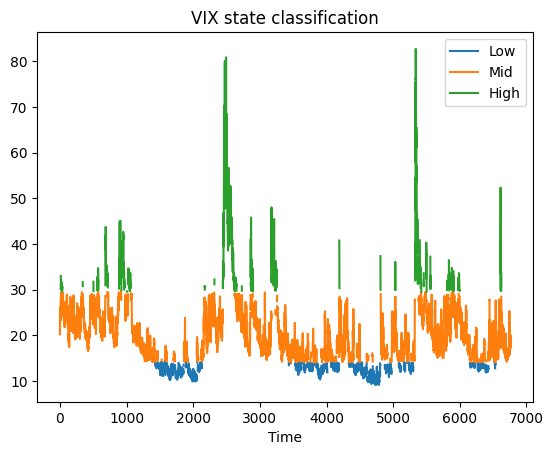

In [8]:
# Plot the 1m implied vol with state classification
vol_low = np.ma.masked_where(low_vol_indices == False, vix)
vol_mid = np.ma.masked_where(mid_vol_indices == False, vix)
vol_high = np.ma.masked_where(high_vol_indices == False, vix)
x = np.arange(0, len(vix))
plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.xlabel('Time')
plt.legend(['Low', 'Mid', 'High'])
plt.title('VIX state classification')
plt.show()

In [9]:
### THE CODE BELOW IS ESSENTIALLY COPY/PASTED FROM EXAMPLE 11 ###

# Exponential decay prior
T_tilde = len(log_returns)
p_exp = ft.exp_decay_probs(log_returns, half_life=T_tilde / 2)

# Compute view values for Entropy Pooling views
mu_low = np.mean(vix[low_vol_indices])
sigma_low = np.std(vix[low_vol_indices])
mu_mid = np.mean(vix[mid_vol_indices])
sigma_mid = np.std(vix[mid_vol_indices])
mu_high = np.mean(vix[high_vol_indices])
sigma_high = np.std(vix[high_vol_indices])

# Specify left hand sides for Entropy Pooling views
A = np.vstack((np.ones((1, T_tilde)), vix[np.newaxis, :]))  # probabilities sum to 1 and mean
b_low = np.array(([[1.], [mu_low]]))
b_mid = np.array(([[1.], [mu_mid]]))
b_high = np.array(([[1.], [mu_high]]))
G = vix[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

# Compute Fully Flexible Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

# Define a Fully Flexible Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

# Create state probabilities and vectors
states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
states_vector = 0 * low_vol_indices + 1 * mid_vol_indices + 2 * high_vol_indices

# Simulate historical observations
S = 10000
H = 21
I = log_returns.shape[-1]
np.random.seed(1)

# Simulate with latest state
sim_indices = resampling(S, H, states_vector[-1], states_prob, states_vector)
return_sim_1m = np.exp(np.cumsum(log_returns[sim_indices], axis=1))[:, -1, :] - 1

In [10]:
# Print simulation stats
stats_sim = ft.simulation_moments(100 * return_sim_1m)
stats_sim.index = data.columns[:-1]
stats_sim

,Mean,Volatility,Skewness,Kurtosis
Ticker,,,,
Materials,1.465228,6.072129,-0.061340,4.261722
Energy,1.536166,7.609585,0.054616,4.506306
Financial,1.549309,6.886470,-0.133658,5.905973
Industrial,1.555344,5.376120,-0.238696,4.345207
Technology,1.819135,6.671161,-0.075965,4.018389
Consumer Staples,1.036073,3.880022,-0.166680,3.938930
Utilities,1.151678,4.880891,-0.113195,3.991338
Health Care,1.294378,4.579705,-0.119415,4.097461
Consumer Discretionary,1.564155,5.935052,-0.237893,3.995426


# Generate single stock P&L using the equity indices

In [11]:
I_stocks = 2000
factor_loadings = np.random.uniform(-0.1, 0.3, size=(I, I_stocks))  # random factor loadings

In [12]:
# Factor loadings stock 1
factor_loadings[:, 0]

array([ 0.27975384,  0.00606992,  0.01995888,  0.08283771,  0.02748529,
        0.01144531,  0.03418518, -0.0258645 ,  0.15937797, -0.01610774])

In [13]:
stock_returns_1m = return_sim_1m @ factor_loadings
print(stock_returns_1m.shape)

(10000, 2000)


# CVaR optimization
With long-only constraints and Entropy Pooling posterior probability vectors (see Chapter 5 in the Portfolio Construction and Risk Management book: https://antonvorobets.substack.com/p/pcrm-book)

In [14]:
G = -np.eye(I_stocks)
h = np.zeros(I_stocks)
cvar_opt = ft.MeanCVaR(stock_returns_1m, G, h)

In [15]:
return_target = np.mean(np.mean(stock_returns_1m, axis=0))
start_time = time()
e_opt_prior = cvar_opt.efficient_portfolio(return_target)
print(f'Prior CVaR efficient portfolio for S={S} scenarios and I={I_stocks} '
      + f'stocks computed in {np.round(time() - start_time, 2)} seconds.')

Prior CVaR efficient portfolio for S=10000 scenarios and I=2000 stocks computed in 3.36 seconds.


In [16]:
# Verify prior results
tol = 1e-10  # tolerence for numerical deviations from bounds
assert np.abs(np.sum(e_opt_prior) - 1) <= tol  # sum to 1
assert np.all(e_opt_prior >= 0 - tol)  # long-only
assert np.abs(np.mean(stock_returns_1m @ e_opt_prior) - return_target) <= tol  # return target

In [17]:
# Entropy Pooling S&P 500 volatility increase for non-uniform scenario probabilities example
A_ep = np.vstack((np.ones((1, S)), return_sim_1m[:, -1][np.newaxis, :]))
b_ep = np.array([[1], [np.mean(return_sim_1m[:, -1]) * 1.1]])  # 10% relative increase in the S&P 500 expected return
q = ft.entropy_pooling(np.ones((S, 1)) / S, A_ep, b_ep)

In [18]:
# Posterior CVaR optimization
cvar_opt_post = ft.MeanCVaR(stock_returns_1m, G, h, p=q)
return_target_post = np.mean(q.T @ stock_returns_1m)
start_time = time()
e_opt_post = cvar_opt_post.efficient_portfolio(return_target_post)
print(f'Posterior CVaR efficient portfolio for S={S} scenarios and I={I_stocks} '
      + f'stocks computed in {np.round(time() - start_time, 2)} seconds.')

Posterior CVaR efficient portfolio for S=10000 scenarios and I=2000 stocks computed in 4.02 seconds.


In [19]:
# Verify posterior results
assert np.abs(np.sum(e_opt_post) - 1) <= tol  # sum to 1
assert np.all(e_opt_post >= 0 - tol)  # long-only
assert np.abs(q.T @ stock_returns_1m @ e_opt_post - return_target_post) <= tol  # return target

# Variance optimization test
Just for comparison, we test how variance optimization performs compared to CVaR. As it turns out, standard quadratic programming struggles when we have to estimate a high-dimensional covariance matrix of size 2000 x 2000.

In [20]:
mean_prior = np.mean(stock_returns_1m, axis=0)
cov_prior = ft.covariance_matrix(stock_returns_1m)
var_opt_prior = ft.MeanVariance(mean_prior, cov_prior, G, h)

In [21]:
e_var_prior = var_opt_prior.efficient_portfolio(return_target)

TypeError: 'P' must be a 'd' matrix of size (2000, 2000)

In [22]:
mean_post = q.T @ stock_returns_1m
cov_post = ft.covariance_matrix(stock_returns_1m, p=q)
var_opt_post = ft.MeanVariance(mean_post[0], cov_post, G, h)

In [23]:
e_var_post = var_opt_post.efficient_portfolio(return_target)

TypeError: 'P' must be a 'd' matrix of size (2000, 2000)

In [ ]:
# fortitudo.tech - Novel Investment Technologies.
# Copyright (C) 2021-2025 Fortitudo Technologies.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.